# Tweede kamer Topic modeling

In [1]:
import pandas as pd
import numpy as np
import gensim
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pickle 
import umap
import re

from pprint import pprint
from collections import defaultdict

import spacy
nlp = spacy.load("nl")

# Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import preprocess_documents, strip_punctuation, strip_numeric, preprocess_string
import pyLDAvis.gensim

## Import data

In [ ]:
## put data chuncks in one zip file
#!cat data/CorpusTweedeKamer* > CorpusTweedeKamer.zip

In [2]:
%%time
tweede_kamer = pd.read_csv("CorpusTweedeKamer.zip")
tweede_kamer = (
    tweede_kamer
    .assign(datum = pd.to_datetime(tweede_kamer.date))
    .assign(speaker = tweede_kamer.speaker.str.lower())
)

CPU times: user 12.9 s, sys: 956 ms, total: 13.9 s
Wall time: 14.1 s


In [3]:
tweede_kamer.shape

(1143366, 12)

In [4]:
tweede_kamer.sample(6)

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,datum
109545,1997-09-10,NaN,48,rabbae,GL,1537.0,False,70,Ik begrijp de inzet van mevrouw Van Ardenne. Z...,NL-TweedeKamer,NLD,1997-09-10
275468,2001-12-11,NaN,363,halsema,GL,1537.0,False,66,Maar wij hebben het hier niet over het uitzett...,NL-TweedeKamer,NLD,2001-12-11
942347,2016-06-23,NaN,55,staatssecretaris dekker,NaN,NaN,False,70,Ik neem het heel graag mee in de evaluatie. Da...,NL-TweedeKamer,NLD,2016-06-23
19784,1995-09-20,NaN,119,wallage,PvdA,1234.0,False,17,Ik ben inderdaad niet zo marxistisch geschoold...,NL-TweedeKamer,NLD,1995-09-20
1091085,2018-11-20,NaN,690,mevrouw buitenweg,GL,1537.0,False,28,"Ja, want daaruit concludeer ik dat het eigenli...",NL-TweedeKamer,NLD,2018-11-20
147842,1998-06-16,NaN,73,rouvoet,RPF,172.0,False,88,Voorzitter! Een van de doelstellingen van deze...,NL-TweedeKamer,NLD,1998-06-16


## TOPIC Modeling with classical LDA

### selection of more recent speeches that are not too short and too long

In [3]:
recente_speeches = (
    tweede_kamer
    .query('datum > "2019-01-01"')
    .query('terms > 50')
    .query('terms < 800')
)
recente_speeches.shape

(19888, 12)

In [6]:
recente_speeches.sample(7)

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,datum
1136132,2019-06-18,NaN,72,de voorzitter,NaN,NaN,True,75,Aan de orde is de vraag van mevrouw Becker ove...,NL-TweedeKamer,NLD,2019-06-18
1138558,2019-06-20,NaN,829,minister van nieuwenhuizen-wijbenga,NaN,NaN,False,82,In mijn denken is een verlaging van de maximum...,NL-TweedeKamer,NLD,2019-06-20
1104241,2019-01-23,NaN,26,de heer wiersma,VVD,828.0,False,110,"We kunnen tegenover elkaar gaan staan, maar mi...",NL-TweedeKamer,NLD,2019-01-23
1104081,2019-01-22,NaN,400,minister bijleveld-schouten,NaN,NaN,False,122,Daar kan ik dan ook niet mee leven omdat EU-de...,NL-TweedeKamer,NLD,2019-01-22
1105002,2019-01-24,NaN,452,de heer verhoeven,D66,45.0,False,182,Dit is wel een mooi voorbeeld. Het laat zien d...,NL-TweedeKamer,NLD,2019-01-24
1104748,2019-01-24,NaN,198,de heer futselaar,SP,1363.0,False,219,Laten we beginnen met de fundamentele discussi...,NL-TweedeKamer,NLD,2019-01-24
1116227,2019-03-07,NaN,668,de heer van rooijen,50PLUS,714.0,False,562,"Voorzitter, dank voor uw inleiding. Het is een...",NL-TweedeKamer,NLD,2019-03-07


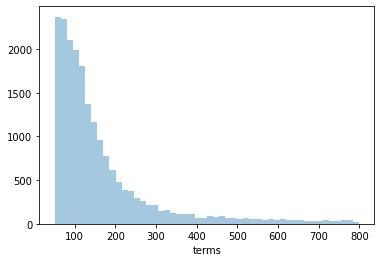

In [7]:
sns.distplot(recente_speeches.terms, kde=False)

### Pre process texts

In [4]:
nlstop = spacy.lang.nl.stop_words.STOP_WORDS
nlstop.update(['minister', 'staatssecretaris', 'voorzitter', 'heer' , 'mevrouw', 'kamer', 'vraag', 'nr.', 'dank', "z'n", '', '-'])

# remove common words and tokenize
print(sorted(nlstop))

['', "'t", '-', 'aan', 'aangaangde', 'aangezien', 'achter', 'achterna', 'af', 'afgelopen', 'al', 'aldus', 'alhoewel', 'alle', 'allebei', 'alleen', 'allen', 'alles', 'als', 'altijd', 'ander', 'andere', 'anderen', 'anders', 'anderzijds', 'behalve', 'beide', 'beiden', 'ben', 'beneden', 'bent', 'bepaald', 'beter', 'betere', 'betreffende', 'bij', 'bijna', 'bijvoorbeeld', 'binnen', 'binnenin', 'boven', 'bovenal', 'bovendien', 'bovenstaand', 'buiten', 'daar', 'daarheen', 'daarin', 'daarna', 'daarnet', 'daarom', 'daarop', 'dan', 'dank', 'dat', 'de', 'den', 'der', 'des', 'deze', 'dezelfde', 'dezen', 'die', 'dien', 'dikwijls', 'dit', 'doch', 'doen', 'doet', 'door', 'doorgaand', 'doorgaans', 'dus', 'echter', 'een', 'eens', 'eerder', 'eerst', 'eerste', 'eersten', 'effe', 'eigen', 'elk', 'elke', 'en', 'enige', 'enkel', 'enkele', 'enz', 'er', 'erdoor', 'etc', 'even', 'eveneens', 'evenwel', 'ff', 'gauw', 'ge', 'gedurende', 'geen', 'gegeven', 'gehad', 'geheel', 'gekund', 'geleden', 'gelijk', 'gemogen'

In [5]:
%%time

texts = [
    [word for word in re.split('[- :,]', document.lower().replace('.',''))  if word not in nlstop]
    for document in recente_speeches.text
]

texts = [
    [str.strip(strip_punctuation(word)) for word in document]
    for document in texts
]

CPU times: user 2.73 s, sys: 80.5 ms, total: 2.81 s
Wall time: 2.86 s


### create dict and corpus

In [6]:
%%time 

dictionary = corpora.Dictionary(texts)
print(dictionary)

#### filter out extremes: too little or too much frequencies.....
dictionary.filter_extremes(
    no_below = 10,
    no_above = 0.925
)

print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(51284 unique tokens: ['150', '2018', '2019', '2030', '49']...)
Dictionary(9722 unique tokens: ['150', '2018', '2019', '2030', '49']...)
CPU times: user 2.49 s, sys: 60.8 ms, total: 2.55 s
Wall time: 2.56 s


### Create LDA

In [7]:
%%time
tweedekamer_lda = LdaModel(corpus, num_topics = 25, id2word = dictionary, passes = 10)

CPU times: user 1min 46s, sys: 1.02 s, total: 1min 47s
Wall time: 1min 47s


In [9]:
lda_topics = tweedekamer_lda.print_topics(num_topics = 25, num_words=12)
lda_topics

[(0,
  '0.062*"vrouwen" + 0.025*"langdurige" + 0.020*"instelling" + 0.019*"bezwaar" + 0.019*"aalst" + 0.017*"aangifte" + 0.016*"afdeling" + 0.015*"ict" + 0.015*"meneer" + 0.013*"systeem" + 0.012*"toestemming" + 0.012*"blik"'),
 (1,
  '0.024*"heel" + 0.021*"mensen" + 0.014*"gaat" + 0.013*"goed" + 0.012*"echt" + 0.012*"maken" + 0.010*"denk" + 0.010*"gaan" + 0.009*"zorgen" + 0.008*"elkaar" + 0.007*"goede" + 0.007*"vind"'),
 (2,
  '0.077*"nederland" + 0.042*"landen" + 0.026*"nederlandse" + 0.017*"land" + 0.016*"europa" + 0.012*"koninkrijk" + 0.011*"europese" + 0.007*"normen" + 0.007*"slachtoffers" + 0.007*"rivm" + 0.007*"buitenland" + 0.006*"eu"'),
 (3,
  '0.225*"—" + 0.025*"gezegd" + 0.020*"zeggen" + 0.018*"vind" + 0.014*"denk" + 0.011*"natuurlijk" + 0.011*"kabinet" + 0.010*"partijen" + 0.010*"heel" + 0.009*"uitspraak" + 0.009*"moment" + 0.008*"zeg"'),
 (4,
  '0.067*"motie" + 0.050*"regering" + 0.043*"overwegende" + 0.042*"verzoekt" + 0.042*"orde" + 0.041*"gaat" + 0.041*"gehoord" + 0.040*

## Create LDA visualisation

In [7]:
### Load already creatwed model and corpus and dict
# tweedekamer_lda = LdaModel.load("lda_2ekamer_model")
# corpus = pickle.load( open("corpus_2ekamer.pck", "rb"))
# dictionary = pickle.load( open ("dict_2ekamer.pck", "rb"))
# vis_data = pickle.load(open("lda_visdata.pck","rb"))


In [10]:
pyLDAvis.enable_notebook(local = True)

In [11]:
%%time 
vis_data = pyLDAvis.gensim.prepare(tweedekamer_lda, corpus, dictionary)

CPU times: user 17.1 s, sys: 344 ms, total: 17.5 s
Wall time: 23.4 s


In [12]:
pyLDAvis.show(vis_data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]
127.0.0.1 - - [02/Sep/2020 08:54:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Sep/2020 08:54:08] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [02/Sep/2020 08:54:08] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Sep/2020 08:54:08] "GET /LDAvis.js HTTP/1.1" 200 -

stopping Server...


In [13]:
pyLDAvis.display(vis_data)

In [14]:
### save model, corpus and dict and ldavis for later use
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("model")
tweedekamer_lda.save("lda_2ekamer_model")

pickle.dump(corpus, open("corpus_2ekamer.pck", "wb"))
pickle.dump(dictionary, open ("dict_2ekamer.pck", "wb"))
pickle.dump(vis_data, open("lda_visdata.pck", "wb"))

## Topic modeling with top2vec